## Face blurring

Isthmus / Mitchellpkt

Leveraging some code from https://realpython.com/traditional-face-detection-python/

## Install libraries

In [1]:
#!pip install opencv-python
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

## Settings

In [2]:
# Variable
path_to_image = os.path.join('inputs','images', 'testfilehalf.png')
privacy_mode = 'blur' # blur block box
blur_intensity = 30

In [3]:
# Static
path_to_model = os.path.join('inputs','models','haarcascade_frontalface_alt.xml')

## Define some functions

In [4]:
def pop_image(image):
    cv.imshow('Image', image)
    cv.waitKey(0)
    cv.destroyAllWindows()

In [5]:
def reverse_colourmap(cmap, name = 'my_cmap_r'):
    """
    In: 
    cmap, name 
    Out:
    my_cmap_r

    Explanation:
    t[0] goes from 0 to 1
    row i:   x  y0  y1 -> t[0] t[1] t[2]
                   /
                  /
    row i+1: x  y0  y1 -> t[n] t[1] t[2]

    so the inverse should do the same:
    row i+1: x  y1  y0 -> 1-t[0] t[2] t[1]
                   /
                  /
    row i:   x  y1  y0 -> 1-t[n] t[2] t[1]
    """        
    reverse = []
    k = []   

    for key in cmap._segmentdata:    
        k.append(key)
        channel = cmap._segmentdata[key]
        data = []

        for t in channel:                    
            data.append((1-t[0],t[2],t[1]))            
        reverse.append(sorted(data))    


## Import image

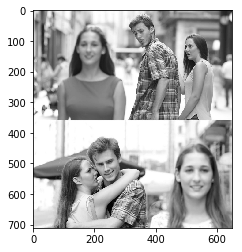

In [6]:
# Read image from your local file system
original_image = cv.imread(path_to_image)
#plt.imshow(original_image)

# Convert color image to grayscale for Viola-Jones
grayscale_image = cv.cvtColor(original_image, cv.COLOR_BGR2GRAY)
plt.imshow(grayscale_image, cmap='gray')

## Load and query classifier

In [7]:
# Load the classifier and create a cascade object for face detection
face_cascade = cv.CascadeClassifier(path_to_model)

In [8]:
detected_faces = face_cascade.detectMultiScale(grayscale_image)

## Filter the image

In [9]:
filtered_image = original_image

if privacy_mode == 'box':
    for (column, row, width, height) in []:#detected_faces:
        cv.rectangle(
            filtered_image,
            (column, row),
            (column + width, row + height),
            (255, 0, 0),
            2
        )
        
if privacy_mode == 'block':
    for (column, row, width, height) in detected_faces:
        cv.rectangle(
            filtered_image,
            (column, row),
            (column + width, row + height),
            (255, 255, 0),
            -1,
        )

if privacy_mode == 'blur':        
    blur_intensity_odd = int(np.floor(blur_intensity/2)*2+1)
    for f in detected_faces:         # For each face in the image
        # Get the origin co-ordinates and the length and width till where the face extends
        x, y, w, h = [ v for v in f ]

        # get the rectangle img around all the faces
        cv.rectangle(filtered_image, (x,y), (x+w,y+h), (255,255,0), 5)
        sub_face = filtered_image[y:y+h, x:x+w]
        # apply a gaussian blur on this new recangle image
        sub_face = cv.GaussianBlur(sub_face,(blur_intensity_odd, blur_intensity_odd), 30)
        # merge this blurry rectangle to our final image
        filtered_image[y:y+sub_face.shape[0], x:x+sub_face.shape[1]] = sub_face



## Show results

Show inline (buggy colors)

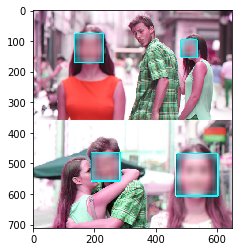

In [10]:
fig = plt.figure
plt.imshow(np.roll(filtered_image,-2))

Popout image (click into & press any key to close)

In [11]:
pop_image(filtered_image)

Save image

In [12]:
face_file_name = "./face_" + str(y) + ".jpg"
#cv.imwrite(face_file_name, sub_face)